## Capstone 3 -Alzheimer's Disease Preprocessing and Training Data Development

The data from the Alzheimer's Disease and Dementia datasets will be prepared below for fitting models.

Each step of the analyses performed below will be in 3 sections, where each one addresses related but different questions:

a. We will examine [clinical measurements and MRI measurements](https://www.kaggle.com/jboysen/mri-and-alzheimers) (note: not images) from Young, Middle Aged, Nondemented or Demented Older Adults to try to predict individual's affected by Alzheimer's disease.

b. We will examine [clinical measurements and MRI measurements](https://www.kaggle.com/jboysen/mri-and-alzheimers) (note: not images) from Nondemented and Demented Older Adults that were imaged at least 2 times in subsequent visits that spanned at least 1 year to try to predict individual's affected or will become affected by Alzheimer's disease.

c. We will examine [MRI image data](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images?select=Alzheimer_s+Dataset) that classifies Alzheimer’s and Dementia patients into 4 classes (non-demented, very mildly demented, mildly demented, and moderately demented). These images will be utilized in attempting to identify which stage of Alzheimer's disease a patient is affected by.

In [1]:
#load necessary packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.image as mpimg
import imageio

import splitfolders
from tensorflow.keras.preprocessing import image

In [2]:
os.getcwd()

'/Users/shannonballard/Springboard/Springboard_Capstone_3'

## Pre-processing and Training Data Development

### Pre-processing and Training Data Development - a

Note that dummy variables were previously created during the Data Cleaning and EDA steps.

In [3]:
#load the data into pandas df and print the first five rows
oasis_cs_for_model = pd.read_csv('oasis_cs_dummies.csv', index_col = 0)
oasis_cs_for_model.head()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,M/F_F,M/F_M,Hand_R
0,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,1,0,1
1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,1,0,1
2,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,1,0,1
8,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,0,1,1
9,52,3.0,2.0,30.0,0.0,1321,0.827,1.329,1,0,1


In [4]:
oasis_cs_for_model.describe()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,M/F_F,M/F_M,Hand_R
count,235.000000,235.000000,235.000000,235.00000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.0
mean,72.344681,3.178723,2.451064,27.06383,0.285106,1459.497872,0.749132,1.216511,0.663830,0.336170,1.0
std,12.091369,1.311510,1.082470,3.69687,0.383405,160.368070,0.047906,0.129427,0.473406,0.473406,0.0
min,33.000000,1.000000,1.000000,14.00000,0.000000,1123.000000,0.644000,0.881000,0.000000,0.000000,1.0
25%,66.000000,2.000000,2.000000,26.00000,0.000000,1348.000000,0.713500,1.133500,0.000000,0.000000,1.0
50%,73.000000,3.000000,2.000000,29.00000,0.000000,1447.000000,0.747000,1.213000,1.000000,0.000000,1.0
75%,81.000000,4.000000,3.000000,30.00000,0.500000,1548.000000,0.784000,1.302000,1.000000,1.000000,1.0
max,96.000000,5.000000,5.000000,30.00000,2.000000,1992.000000,0.847000,1.563000,1.000000,1.000000,1.0


In [48]:
# Make and save a figure of dataset description
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(columnwidth = [60,275, 100], header=dict(values=['Variable', 'Details', 'Type']),
                 cells=dict(values=[['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR',
                                    'eTIV', 'nWBV', 'ASF', 'Delay'],
                                    ['Image identification number', 'Gender of patient (M=male and F=female)', 'Patient handedness (right or left)',
                                    'Age of patients (in years)', 'Level of education (1 = lowest and 5 = highest)', 'Socioeconomic status (1 = highest status, 5 = lowest status)',
                                    'Mini mental state examination', 'Clinical dementia rating (0 = no dementia, 0.5 = very mild dementia, 1 = mild dementia, 2 = moderate dementia, 3 = severe dementia)',
                                    'Estimated total intracranial volume (cm3)', 'Normalized whole brain volumes', 'Atlas scaling factor - comparison of eTIV based on normalization of head size',
                                    'Delay time before imaging in real time'], 
                                    ['Continuous', 'Categorical', 'Categorical', 'Continuous', 'Categorical', 'Categorical',
                                    'Continuous/Categorical', 'Categorical', 'Continuous', 'Continuous', 'Continuous', 'Continuous']]))
                     ])
fig.update_layout(
    title={
        'text': "Description of Data",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, width=800,
    height=550)
fig.write_image('Table 1_Description of Data.png')
fig.show()

Because this dataset does not include a binary feature to designate Alzheimer's Disease in the participant, we will use the CDR as our response variable. The CDR is the clinical dementia ratint, and a score of 0 indicates no dementia. The other classes in this feature within this dataset are: very mild dementia (0.5), mild dementia (1), and moderate dementia (2).

We can look at the number of participants in each class.

In [6]:
num_cdr = oasis_cs_for_model['CDR'].value_counts()
num_cdr

0.0    135
0.5     70
1.0     28
2.0      2
Name: CDR, dtype: int64

The no dementia class in the largest. We will create a dummy variable for this value. This feature will be the response variable.

Alternatively, we could do multi-class classification, but because the dataset is imbalanced for the CDR feature (for example only 2 participants with a CDR of 2), we will consider any value equal to or greater than 0.5 to be classified as demented.

In [7]:
oasis_cs_for_model = pd.get_dummies(oasis_cs_for_model, prefix=['CDR'], columns=['CDR'])
oasis_cs_for_model.head()

,Age,Educ,SES,MMSE,eTIV,nWBV,ASF,M/F_F,M/F_M,Hand_R,CDR_0.0,CDR_0.5,CDR_1.0,CDR_2.0
0,74,2.0,3.0,29.0,1344,0.743,1.306,1,0,1,1,0,0,0
1,55,4.0,1.0,29.0,1147,0.810,1.531,1,0,1,1,0,0,0
2,73,4.0,3.0,27.0,1454,0.708,1.207,1,0,1,0,1,0,0
8,74,5.0,2.0,30.0,1636,0.689,1.073,0,1,1,1,0,0,0
9,52,3.0,2.0,30.0,1321,0.827,1.329,1,0,1,1,0,0,0


In [8]:
# Create csv file for oasis_cs_for_model to use in future analyses
oasis_cs_for_model.to_csv('oasis_cs_for_model.csv', index=False)

In [9]:
# Declare an explanatory variable, called X, and assign it the result of dropping 'CDR_0.0' from the df
X = oasis_cs_for_model.drop(['CDR_0.0'], axis=1)

# Declare a response variable, called y, and assign it the 'CDR_0.0' column of the df 
y = oasis_cs_for_model['CDR_0.0']

In [10]:
# Change y from Series to array
y = y.ravel()

In [11]:
# Import the train_test_split function from the sklearn.model_selection  
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Using 75/25 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [12]:
# Check the number of participants in training dataset
print("Number of participants in the X_train dataset: ", X_train.shape)
print("Number of participants in the y_train dataset: ", y_train.shape)
print("Number of participants in the X_test dataset: ", X_test.shape)
print("Number of participants in the y_test dataset: ", y_test.shape)

Number of participants in the X_train dataset:  (176, 13)
Number of participants in the y_train dataset:  (176,)
Number of participants in the X_test dataset:  (59, 13)
Number of participants in the y_test dataset:  (59,)


#### Standardize the magnitude of the numeric features using a scaler

Because the values in the columns have different magnitudes, the data will be standardized. 

In [13]:
from sklearn.preprocessing import StandardScaler

# Instantiate scaler
scaler = StandardScaler()

In [14]:
# Fit scaler to X_train data
X_train_scaled = scaler.fit(X_train)
X_train_scaled_values = scaler.transform(X_train)

# Create df with scaled_values
X_train_scaled = pd.DataFrame(X_train_scaled_values, index = X_train.index.values, columns = X_train.columns.values)
X_train = X_train_scaled

# Fit scaler to X_test data
X_test_scaled_values = scaler.fit_transform(X_test)

# Create df with scaled_values
X_test_scaled = pd.DataFrame(X_test_scaled_values, index = X_test.index.values, columns = X_test.columns.values)
X_test = X_test_scaled

### Pre-processing and Training Data Development - b

Note that dummy variables were previously created during the Data Cleaning and EDA steps.

In [15]:
#load the data into pandas df and print the first five rows
oasis_lon_for_model = pd.read_csv('oasis_lon_dummies.csv', index_col = 0)
oasis_lon_for_model.head()

,Subject ID,MRI ID,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,...,Group_Demented,Group_Nondemented,Visit_1,Visit_2,Visit_3,Visit_4,Visit_5,M/F_F,M/F_M,Hand_R
0,OAS2_0001,OAS2_0001_MR1,0,87,14,2.0,27.0,0.0,1987,0.696,...,0,1,1,0,0,0,0,0,1,1
1,OAS2_0001,OAS2_0001_MR2,457,88,14,2.0,30.0,0.0,2004,0.681,...,0,1,0,1,0,0,0,0,1,1
2,OAS2_0002,OAS2_0002_MR1,0,75,12,2.0,23.0,0.5,1678,0.736,...,1,0,1,0,0,0,0,0,1,1
3,OAS2_0002,OAS2_0002_MR2,560,76,12,2.0,28.0,0.5,1738,0.713,...,1,0,0,1,0,0,0,0,1,1
4,OAS2_0002,OAS2_0002_MR3,1895,80,12,2.0,22.0,0.5,1698,0.701,...,1,0,0,0,1,0,0,0,1,1


In [16]:
# drop subject ID and MRI ID columns
oasis_lon_for_model = oasis_lon_for_model.drop(['Subject ID', 'MRI ID'], axis = 1)


In [17]:
oasis_lon_for_model.describe()

,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Group_Converted,Group_Demented,Group_Nondemented,Visit_1,Visit_2,Visit_3,Visit_4,Visit_5,M/F_F,M/F_M,Hand_R
count,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.0
mean,595.104558,77.013405,14.597855,2.436997,27.356568,0.290885,1488.128686,0.729568,1.195461,0.099196,0.391421,0.509383,0.402145,0.386059,0.155496,0.040214,0.016086,0.571046,0.428954,1.0
std,635.485118,7.640957,2.876339,1.109307,3.678467,0.374557,176.139286,0.037135,0.138092,0.299326,0.488724,0.500583,0.490989,0.487498,0.362864,0.196726,0.125975,0.495592,0.495592,0.0
min,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0
75%,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0
max,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [18]:
# Create csv file for oasis_cs_for_model to use in future analyses
oasis_lon_for_model.to_csv('oasis_lon_for_model.csv', index=False)

In [19]:
# Make and save a figure of dataset description
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(columnwidth = [60,300, 100], header=dict(values=['Variable', 'Details', 'Type']),
                 cells=dict(values=[['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR',
                                    'eTIV', 'nWBV', 'ASF'],
                                    ['Subject Identification number', 'MRI identification number', 'Demented, Nondemented, or Converted (developed disease during study)', 'Which visit image was taken', 'Number of days since first image', 'Gender of patient (M=male and F=female)', 'Patient handedness (right or left)',
                                    'Age of patients (in years)', 'Number of years of education', 'Socioeconomic status (1 = highest status, 5 = lowest status)',
                                    'Mini mental state examination (see Table 2)', 'Clinical dementia rating (0 = no dementia, 0.5 = very mild dementia, 1 = mild dementia, 2 = moderate dementia, 3 = severe dementia)',
                                    'Estimated total intracranial volume (cm3)', 'Normalized whole brain volumes', 'Atlas scaling factor - comparison of eTIV based on normalization of head size'], 
                                    ['Continuous', 'Continuous', 'Categorical', 'Categorical', 'Continuous', 'Categorical',
                                    'Categorical', 'Continuous', 'Categorical', 'Categorical', 'Categorical/Continuous', 'Categorical', 'Continuous', 'Continuous', 'Continuous']]))
                     ])
fig.update_layout(
    title={
        'text': "Table 3: Description of Longitudinal Data",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, width=800,
    height=650)
fig.write_image('Table 3_Description of Longitudinal Data.png')
fig.show()

This dataset includes a feature termed 'Group', where the participants are determined to be Demented or Non-Demented. Dummy variables were previously created for the 'Group' column. To remain consistent with the dataset in section a, we will use Group_Nondemented as the response variable.

In [20]:
# Declare an explanatory variable, called X, and assign it the result of dropping 'Group_demented' from the df
X_lon = oasis_lon_for_model.drop(['Group_Nondemented'], axis=1)

# Declare a response variable, called y, and assign it the 'Group_demented' column of the df 
y_lon = oasis_lon_for_model['Group_Nondemented']

In [21]:
# Change y from Series to array
y_lon = y_lon.ravel()

In [22]:
# Import the train_test_split function from the sklearn.model_selection  
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Using 75/25 split
X_lon_train, X_lon_test, y_lon_train, y_lon_test = train_test_split(X_lon, y_lon, test_size=0.25, random_state=1)

In [23]:
print("Number of participants in the X_lon_train dataset: ", X_lon_train.shape)
print("Number of participants in the y_lon_train dataset: ", y_lon_train.shape)
print("Number of participants in the X__lon_test dataset: ", X_lon_test.shape)
print("Number of participants in the y_lon_test dataset: ", y_lon_test.shape)

Number of participants in the X_lon_train dataset:  (279, 19)
Number of participants in the y_lon_train dataset:  (279,)
Number of participants in the X__lon_test dataset:  (94, 19)
Number of participants in the y_lon_test dataset:  (94,)


#### Standardize the magnitude of the numeric features using a scaler

Because the values in the columns have different magnitudes, the data will be standardized. 

In [24]:
from sklearn.preprocessing import StandardScaler

# Instantiate scaler
scaler_lon = StandardScaler()

In [25]:
# Fit scaler to X_train data
X_lon_train_scaled = scaler_lon.fit(X_lon_train)
X_lon_train_scaled_values = scaler_lon.transform(X_lon_train)

# Create df with scaled_values
X_lon_train_scaled = pd.DataFrame(X_lon_train_scaled_values, index = X_lon_train.index.values, columns = X_lon_train.columns.values)
X_lon_train = X_lon_train_scaled

# Fit scaler to X_test data
X_lon_test_scaled_values = scaler_lon.fit_transform(X_lon_test)

# Create df with scaled_values
X_lon_test_scaled = pd.DataFrame(X_lon_test_scaled_values, index = X_lon_test.index.values, columns = X_lon_test.columns.values)
X_lon_test = X_lon_test_scaled

### Pre-processing and Training Data Development - c

Note that these steps were previously performed in the Data Wrangling and EDA portion. However, the split was Train = 80%, Validation = 10%, Test = 10%. This will be changed to 70, 15, 15, respectively. This is because there are very few images for Moderate Demented class (see below for accounting for these few images).

In [26]:
#Split images classes into train, validation, and test sets
#Train = 70%, Validation = 15%, Test = 15%

import splitfolders
splitfolders.ratio('images/Images', output="output_images2", seed=1337, ratio=(.7, 0.15,0.15))

Copying files: 6400 files [00:18, 348.61 files/s]


There is a class imbalance with the image dataset, which can ultimately affect the accuracy score of the model as the classes with more images will have high accuracy, yet the model will not learn from the classes with fewer images. Thus, we will perform image augmentation, where random over-sampling will be performed. Note that we did not choose to perform downsampling (under-sampling) and remove images from the dataset to balance the classes.

To better understand how to perform over-sampling with image analysis, this [article](https://towardsdatascience.com/deep-learning-in-healthcare-x-ray-imaging-part-4-the-class-imbalance-problem-364eff4d47bb) as well as this [article](https://medium.com/@thimblot/data-augmentation-boost-your-image-dataset-with-few-lines-of-python-155c2dc1baec) were used as a resource. The code in the articles is used below. However, it should be noted that some aspects of the code needed to be altered or added to below to run properly.

We will only do oversampling on test images that were generated when we split the dataset.

In [27]:
os.getcwd()

'/Users/shannonballard/Springboard/Springboard_Capstone_3'

In [28]:
# Check number of images in training sets
myPath = "/Users/shannonballard/Springboard/Springboard_Capstone_3/output_images2/train/NonDemented"
non = len([f for f in os.listdir(myPath) 
     if f.endswith('.jpg') and os.path.isfile(os.path.join(myPath, f))])

verymild_myPath = "/Users/shannonballard/Springboard/Springboard_Capstone_3/output_images2/train/VeryMildDemented"
verymild = len([f for f in os.listdir(verymild_myPath) 
     if f.endswith('.jpg') and os.path.isfile(os.path.join(verymild_myPath, f))])

mild_myPath = "/Users/shannonballard/Springboard/Springboard_Capstone_3/output_images2/train/MildDemented"
mild = len([f for f in os.listdir(mild_myPath) 
     if f.endswith('.jpg') and os.path.isfile(os.path.join(mild_myPath, f))])

mod_myPath = "/Users/shannonballard/Springboard/Springboard_Capstone_3/output_images2/train/ModerateDemented"
mod = len([f for f in os.listdir(mod_myPath) 
     if f.endswith('.jpg') and os.path.isfile(os.path.join(mod_myPath, f))])

In [29]:
print('The number of images in the NonDemented training set is', non)
print('The number of images in the VeryMildDemented training set is', verymild)
print('The number of images in the MildDemented training set is', mild)
print('The number of images in the ModerateDemented training set is', mod)

The number of images in the NonDemented training set is 2240
The number of images in the VeryMildDemented training set is 1568
The number of images in the MildDemented training set is 627
The number of images in the ModerateDemented training set is 44


In [30]:
#check the difference from the majority class
non_verymild_diff = non-verymild
non_mild_diff = non-mild
non_mod_diff = non-mod

print(non_verymild_diff)
print(non_mild_diff)
print(non_mod_diff)

672
1613
2196


The images will be altered in 3 different ways:
1. rotating the image at random from -10 to +10 degrees
2. flipping the images around the left/right axes (switching left and right sides)  
3. Blurring the images using the bilateral filter at random. This preserves edges by using 2 Gaussian functions:
    a. space - blurs only pixels near each other
    b. intensity - blurs only pixels that have intensities similar to the central pixel

In [31]:
import cv2 as cv
import random

In [32]:
# Image alterations
def rotate_image(image, scale =1.0, h=208, w = 176):
    center = (h/2,w/2)
    angle = random.randint(-10,10)
    M = cv.getRotationMatrix2D(center, angle, scale)
    rotated = cv.warpAffine(image, M, (h,w))
    return rotated

def flip_image(image):
    flipped = np.fliplr(image)
    return flipped

def blur_image(image):
    x = random.randrange(1,5,2)
    blur = cv.GaussianBlur(image,(x,x),cv.BORDER_DEFAULT)
    return blur


In [33]:
from scipy import ndarray
import skimage as sk
import skimage.io

In [34]:
# our folder path containing some images
verymild_myPath
# the number of file to generate
num_files_desired = non_verymild_diff

images = [os.path.join(verymild_myPath, f) for f in os.listdir(verymild_myPath) if os.path.isfile(os.path.join(verymild_myPath, f))]


In [35]:
num_generated_files = 0
image_to_transform = []

while num_generated_files < non_verymild_diff:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform.append(sk.io.imread(image_path))
    num_generated_files += 1

print(len(image_to_transform))


672


In [36]:
available_transformations = {
    'rotate': rotate_image,
    'lr_flip': flip_image,
    'blur': blur_image
}

# random num of transformations to apply
num_transformations_to_apply = random.randint(1, len(available_transformations))

num_transformations = 0
transformed_image = None

for i in range(1, 673):
    # choose a random transformation to apply for a single image
    key = random.choice(list(available_transformations))
    transformed_image = available_transformations[key](random.choice(image_to_transform))
    num_transformations += 1
    # define a name for our new file
    new_file_path = '%s/augmented_image_%s.jpg' % (verymild_myPath, num_transformations)
    # write image to the disk
    sk.io.imsave(new_file_path, transformed_image)

print(num_transformations)

672


In [37]:
# our folder path containing some images
mild_myPath
# the number of file to generate
num_files_desired = non_mild_diff

images_mild = [os.path.join(mild_myPath, f) for f in os.listdir(mild_myPath) if os.path.isfile(os.path.join(mild_myPath, f))]


In [38]:
mild_num_generated_files = 0
mild_image_to_transform = []

while mild_num_generated_files < 1613:
    # random image from the folder
    mild_image_path = random.choice(images_mild)
    # read image as an two dimensional array of pixels
    mild_image_to_transform.append(sk.io.imread(mild_image_path))
    mild_num_generated_files += 1

print(len(mild_image_to_transform))


1613


In [39]:
available_transformations = {
    'rotate': rotate_image,
    'lr_flip': flip_image,
    'blur': blur_image
}

# random num of transformations to apply
mild_num_transformations_to_apply = random.randint(1, len(available_transformations))

mild_num_transformations = 0
mild_transformed_image = None

for i in range(1, 1614):
    # choose a random transformation to apply for a single image
    key = random.choice(list(available_transformations))
    mild_transformed_image = available_transformations[key](random.choice(mild_image_to_transform))
    mild_num_transformations += 1
    # define a name for our new file
    mild_new_file_path = '%s/mild_augmented_image_%s.jpg' % (mild_myPath, mild_num_transformations)
    # write image to the disk
    sk.io.imsave(mild_new_file_path, mild_transformed_image)

print(mild_num_transformations)

1613


In [40]:
# our folder path containing some images
mod_myPath
# the number of file to generate
num_files_desired = non_mod_diff

images_mod = [os.path.join(mod_myPath, f) for f in os.listdir(mod_myPath) if os.path.isfile(os.path.join(mod_myPath, f))]


In [41]:
mod_num_generated_files = 0
mod_image_to_transform = []

while mod_num_generated_files < non_mod_diff:
    # random image from the folder
    mod_image_path = random.choice(images_mod)
    # read image as an two dimensional array of pixels
    mod_image_to_transform.append(sk.io.imread(mod_image_path))
    mod_num_generated_files += 1

print(len(mod_image_to_transform))


2196


In [42]:
available_transformations = {
    'rotate': rotate_image,
    'lr_flip': flip_image,
    'blur': blur_image
}

# random num of transformations to apply
mod_num_transformations_to_apply = random.randint(1, len(available_transformations))

mod_num_transformations = 0
mod_transformed_image = None

for i in range(1, 2197):
    # choose a random transformation to apply for a single image
    key = random.choice(list(available_transformations))
    mod_transformed_image = available_transformations[key](random.choice(mod_image_to_transform))
    mod_num_transformations += 1
    # define a name for our new file
    mod_new_file_path = '%s/mod_augmented_image_%s.jpg' % (mod_myPath, mod_num_transformations)
    # write image to the disk
    sk.io.imsave(mod_new_file_path, mod_transformed_image)

print(mod_num_transformations)

2196


In [43]:
# Check number of images in training sets
myPath = "/Users/shannonballard/Springboard/Springboard_Capstone_3/output_images2/train/NonDemented"
non = len([f for f in os.listdir(myPath) 
     if f.endswith('.jpg') and os.path.isfile(os.path.join(myPath, f))])

verymild_myPath = "/Users/shannonballard/Springboard/Springboard_Capstone_3/output_images2/train/VeryMildDemented"
verymild = len([f for f in os.listdir(verymild_myPath) 
     if f.endswith('.jpg') and os.path.isfile(os.path.join(verymild_myPath, f))])

mild_myPath = "/Users/shannonballard/Springboard/Springboard_Capstone_3/output_images2/train/MildDemented"
mild = len([f for f in os.listdir(mild_myPath) 
     if f.endswith('.jpg') and os.path.isfile(os.path.join(mild_myPath, f))])

mod_myPath = "/Users/shannonballard/Springboard/Springboard_Capstone_3/output_images2/train/ModerateDemented"
mod = len([f for f in os.listdir(mod_myPath) 
     if f.endswith('.jpg') and os.path.isfile(os.path.join(mod_myPath, f))])

In [44]:
print('The number of images in the NonDemented training set is', non)
print('The number of images in the VeryMildDemented training set is', verymild)
print('The number of images in the MildDemented training set is', mild)
print('The number of images in the ModerateDemented training set is', mod)

The number of images in the NonDemented training set is 2240
The number of images in the VeryMildDemented training set is 2240
The number of images in the MildDemented training set is 2240
The number of images in the ModerateDemented training set is 2240


The number of images for each class is now equal.

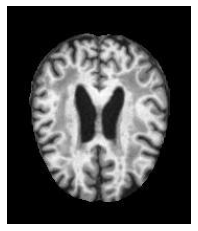

In [45]:
# Look at one of the altered images for each class
verymild_img = mpimg.imread('output_images2/train/VeryMildDemented/augmented_image_1.jpg')
imgplot = plt.imshow(verymild_img, cmap="gray")
plt.axis('off')
plt.show()

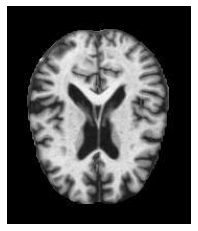

In [46]:
mild_img = mpimg.imread('output_images2/train/MildDemented/mild_augmented_image_1.jpg')
imgplot = plt.imshow(mild_img, cmap="gray")
plt.axis('off')
plt.show()

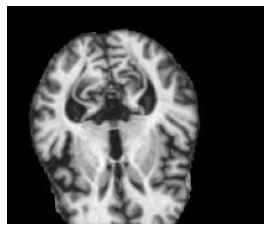

In [47]:
mod_img = mpimg.imread('output_images2/train/ModerateDemented/mod_augmented_image_1.jpg')
imgplot = plt.imshow(mod_img, cmap="gray")
plt.axis('off')
plt.show()